# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [6]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [4]:
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info.head(20)

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown'].replace({'[-1,X]':'[-1,"X"]',
                                        '[-1,XX]':'[-1,"XX"]',
                                         '[XX]':'["XX"]',
                                        }, inplace=True)

In [8]:
na_encodings = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
na_encodings = {key: {k: np.nan for k in literal_eval(value)} for key, value in na_encodings.items()} 

In [9]:
for column, mapping in na_encodings.items():
    azdias[column].replace(mapping, inplace = True)             

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5,1,'Features with Missing Observations')

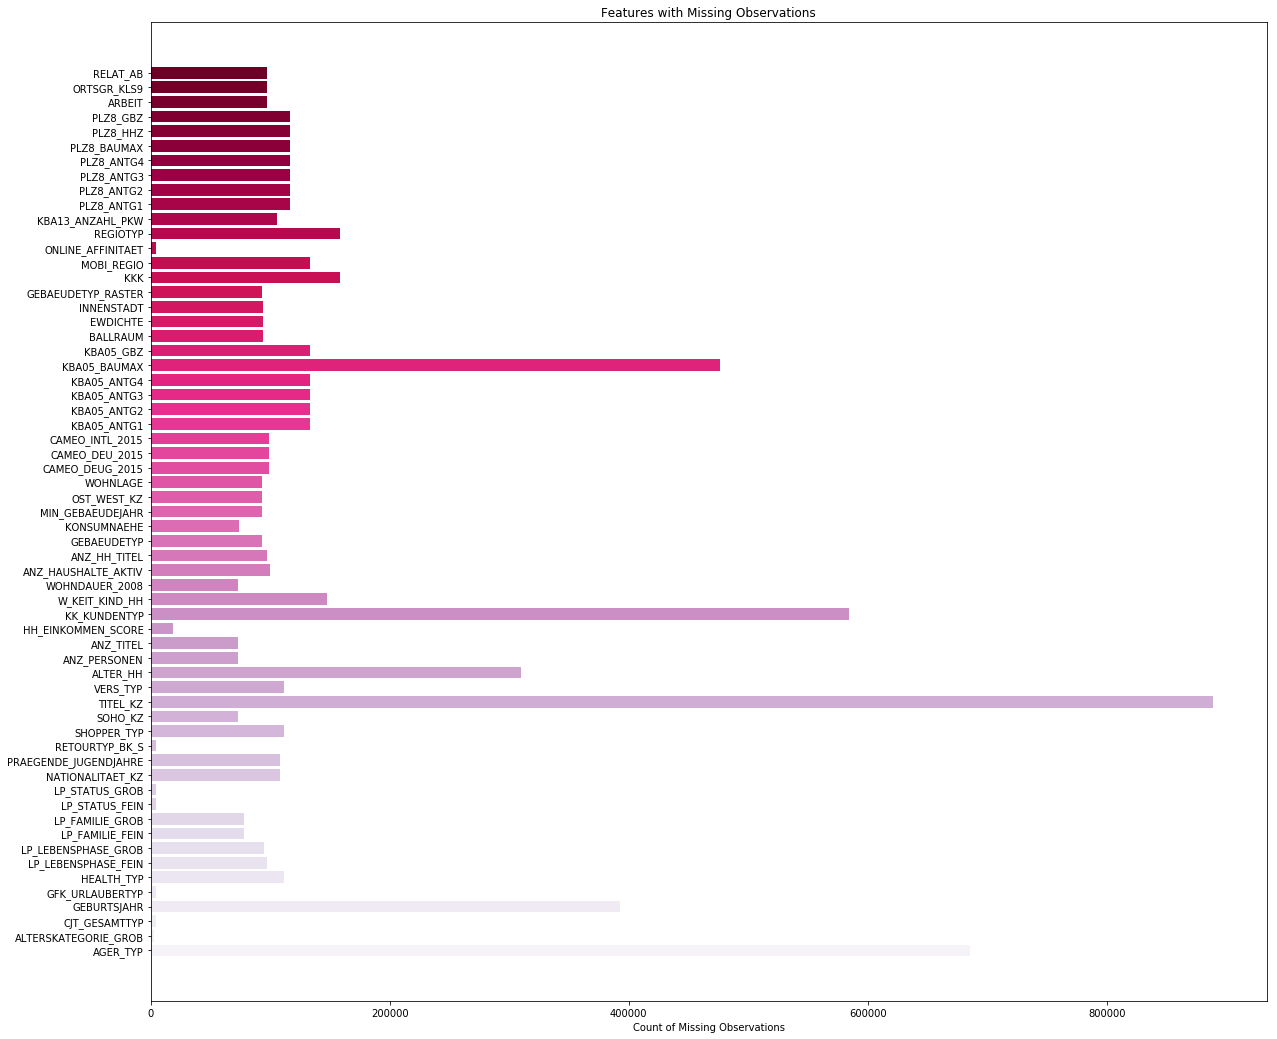

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#msno.bar(azdias)
columns_with_missing_values = azdias.columns[azdias.isnull().any()]
labels = []  
valuecount = [] 

for col in columns_with_missing_values:
    labels.append(col)
    valuecount.append(azdias[col].isnull().sum())
    
ind = np.arange(len(labels))

fig = plt.figure(figsize=(20,18))
ax = fig.gca()
missing_plot = plt.barh(ind, np.array(valuecount), color = sns.color_palette("PuRd", len(ind)))
ax.set_yticks(ind)
ax.set_yticklabels(labels, rotation = 'horizontal')
ax.set_xlabel("Count of Missing Observations")
ax.set_title("Features with Missing Observations")

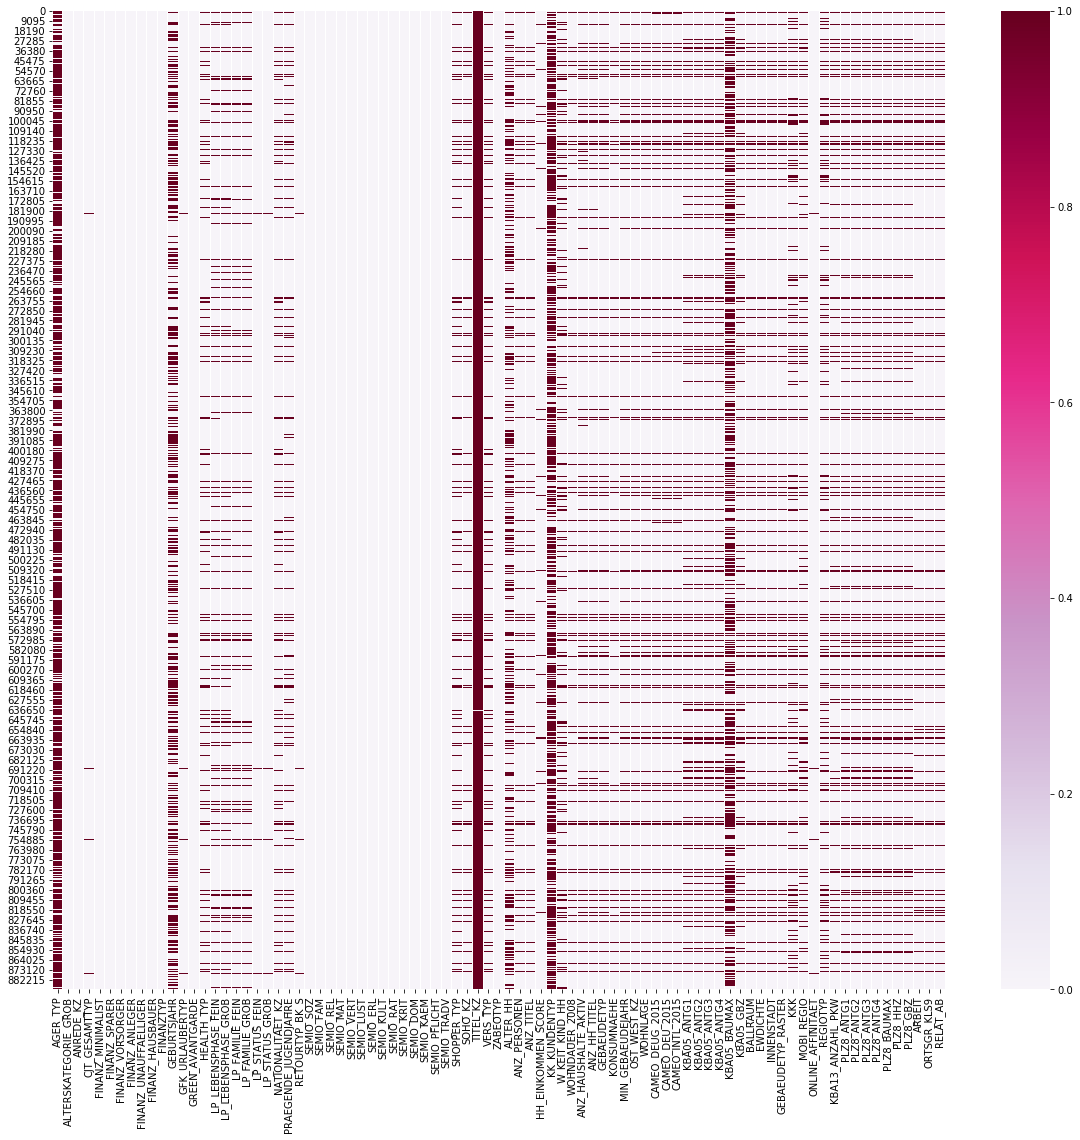

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize = (20,18))
sns.heatmap(azdias.isnull(), cmap = 'PuRd')

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_na_count = pd.DataFrame(azdias.isnull().sum())
azdias_na_count.columns = ['na_count']
outlier_cols = list(azdias_na_count[azdias_na_count['na_count'] > 180000].index)

In [14]:
feat_info[feat_info['attribute'].isin(outlier_cols)]

attribute information_level         type missing_or_unknown
0       AGER_TYP            person  categorical             [-1,0]
11   GEBURTSJAHR            person      numeric                [0]
40      TITEL_KZ            person  categorical             [-1,0]
43      ALTER_HH         household     interval                [0]
47  KK_KUNDENTYP         household  categorical               [-1]
64  KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]

In [12]:
azdias0 = azdias.drop(outlier_cols, axis=1)

In [13]:
print(outlier_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

The columns 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX' were removed from the azdias data set for having over 180,000 missing observations. Upon inspection of the bar chart showing the count of missing observations, it became obvious that these columns are outliers. Other cloumns had noticeable counts of missing observations, but often came in duplicates indicating that the missing observations are stemming from individuals.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
azdias_row_na = pd.DataFrame(azdias.isnull().sum(axis=1))
azdias_row_na.columns = ['na_count']
azdias_row_na.describe()

na_count
count  891221.000000
mean        9.396018
std        13.971829
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        54.000000

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# I will choose 18 missing values as the cut off
outlier_rows = list(azdias_row_na[azdias_row_na['na_count'] > 18].index)

In [16]:
print(len(outlier_rows))
print(len(azdias.index))
print(len(outlier_rows)/len(azdias.index))

102079
891221
0.11453836927092158


In [17]:
azdias1 = azdias.drop(outlier_rows)

In [18]:
azdias1.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  199790.000000         786435.000000  789142.000000  784838.000000   
mean        1.731233              2.796644       1.521373       3.500903   
std         0.676127              1.018678       0.499543       1.537093   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      789142.000000  789142.000000     789142.000000   789142.000000   
mean            3.056498       2.712702          3.436399        2.838359   
std             1.377620       1.485781          1.377201        1.472612   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          2.000000        1.000000   
50%             3.000000       3.000000          4.000000        3.000000   
75%             4.000000       4.000000          5.000000        4.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...           PLZ8_ANTG1  \
count          789142.000000     789142.000000      ...        773876.000000   
mean                2.644829          3.128791      ...             2.253078   
std                 1.396081          1.403606      ...             0.972074   
min                 1.000000          1.000000      ...             0.000000   
25%                 1.000000          2.000000      ...             1.000000   
50%                 2.000000          3.000000      ...             2.000000   
75%                 4.000000          4.000000      ...             3.000000   
max                 5.000000          5.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  773876.000000  773876.000000  773876.000000  773876.000000   
mean        2.802104       1.595778       0.699367       1.944317   
std         0.920308       0.986735       0.727212       1.459817   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  773876.000000  773876.000000  784989.000000  785083.000000   
mean        3.612849       3.380797       3.170255       5.299065   
std         0.973850       1.111596       0.998014       2.302508   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       5.000000       9.000000   

            RELAT_AB  
count  784989.000000  
mean        3.074639  
std         1.360000  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  

[8 rows x 81 columns]

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_dist(azdias_row_na, column, threshold = 18):
    few_na = list(azdias_row_na[azdias_row_na['na_count'] < threshold].index)
    many_na = list(azdias_row_na[azdias_row_na['na_count'] > threshold].index)
    
    azdias_few_na = azdias.loc[few_na, :]
    azdias_many_na = azdias.loc[many_na, :]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,6))
    sns.barplot(x = column, 
                y = column, 
                ax = ax1, 
                data = azdias_few_na, 
                estimator = lambda x: len(x)/len(azdias_few_na)*100, 
                palette="PuRd")
    ax1.set_title("Few NA's")
    sns.barplot(x = column, 
                y = column, 
                ax = ax2, 
                data = azdias_many_na, 
                estimator = lambda x: len(x)/len(azdias_many_na)*100, 
                palette="PuRd")
    ax2.set_title("Many NA's")
    plt.ylabel("% of total")
    plt.suptitle(column)

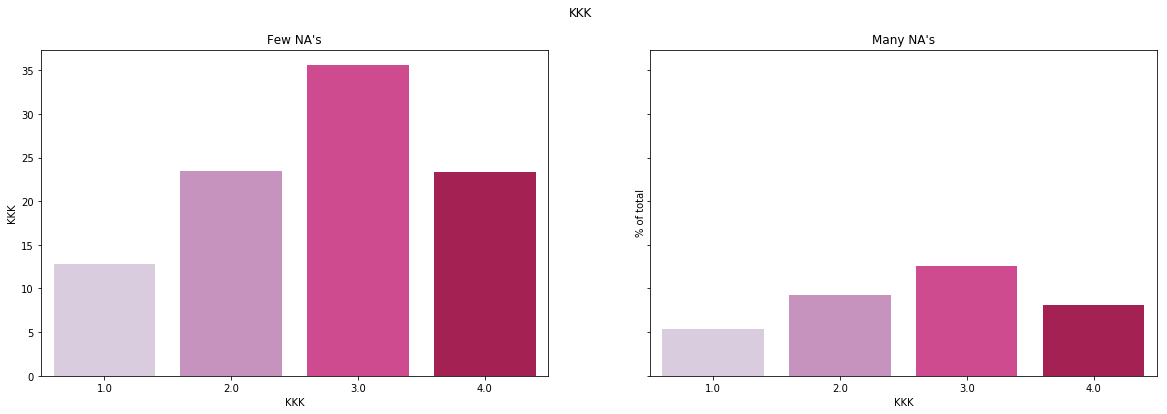

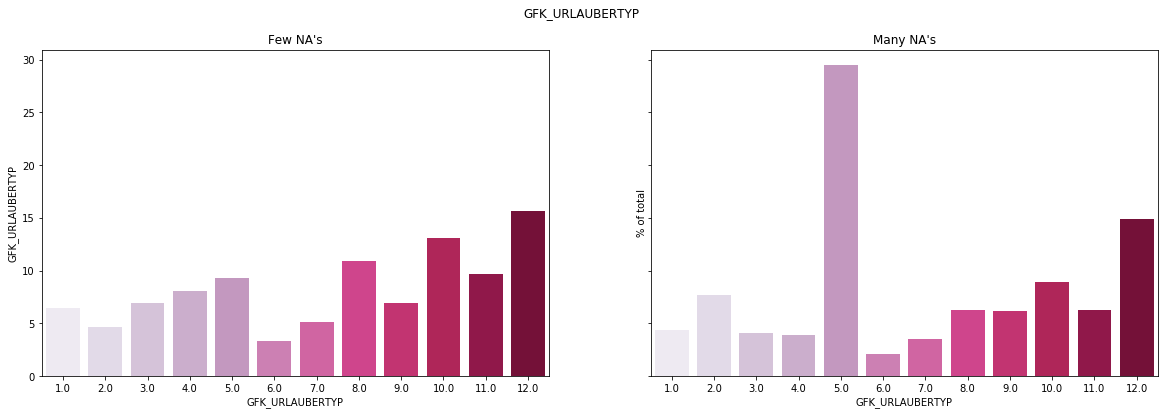

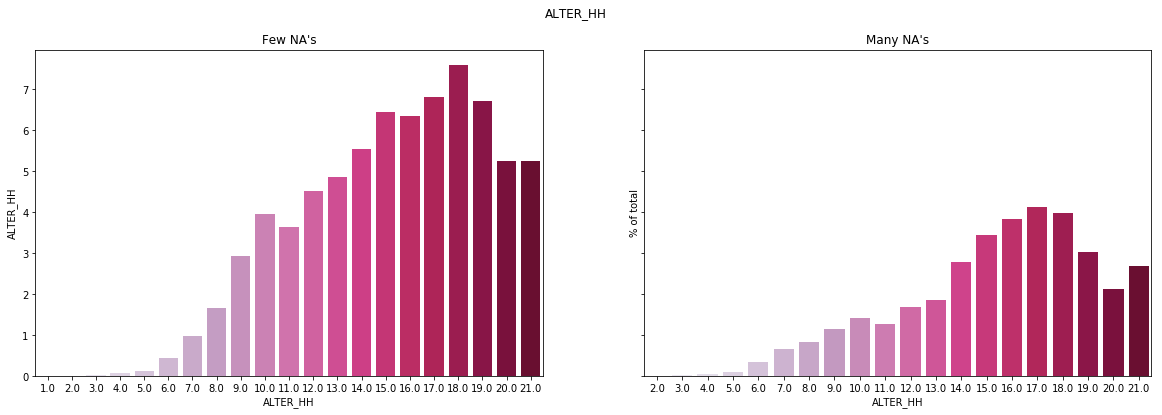

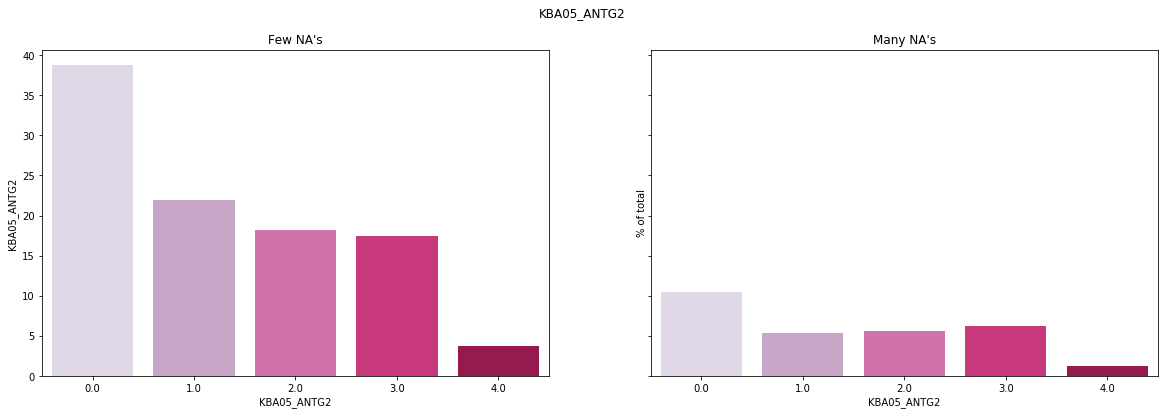

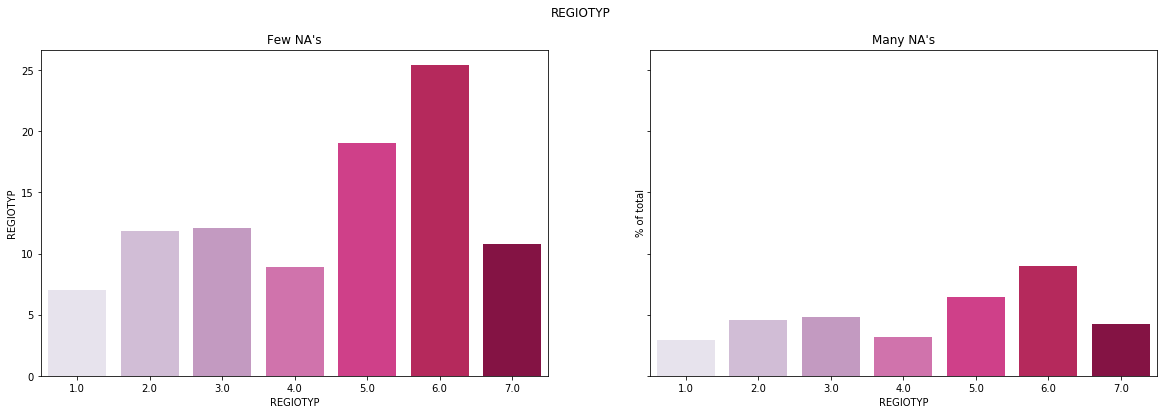

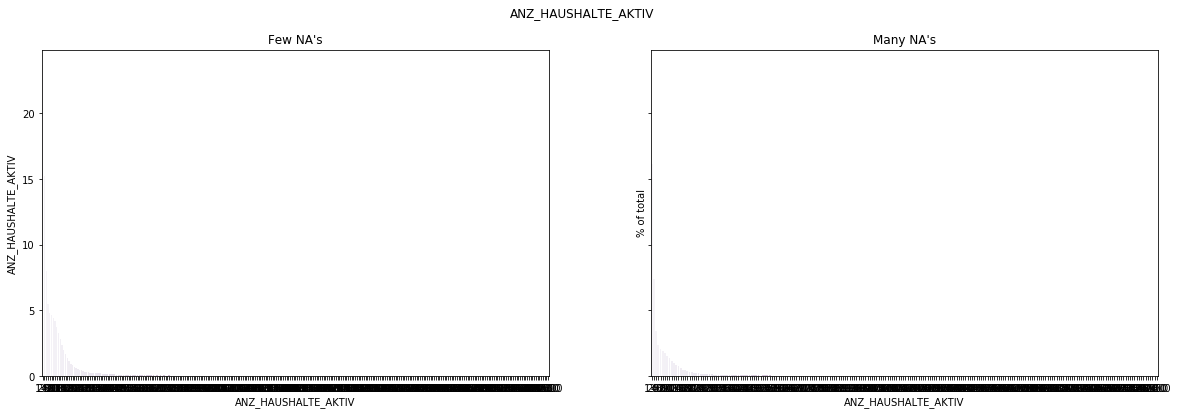

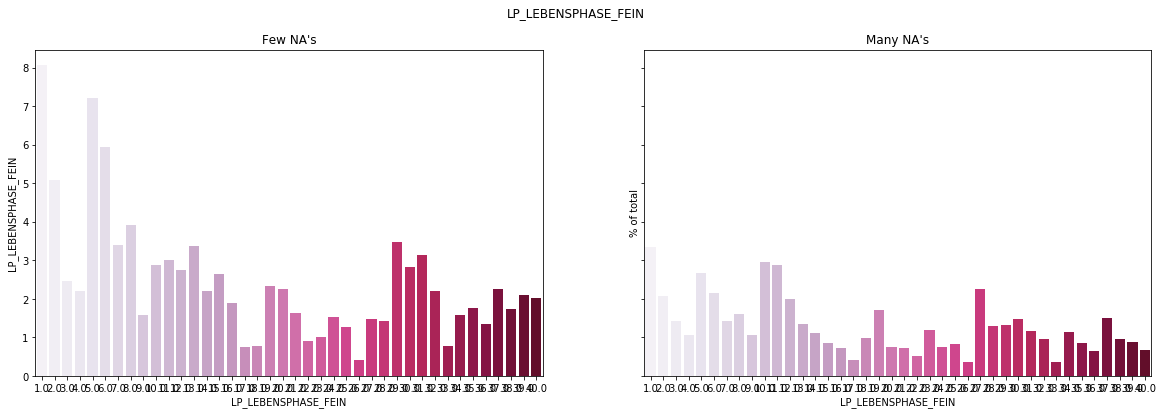

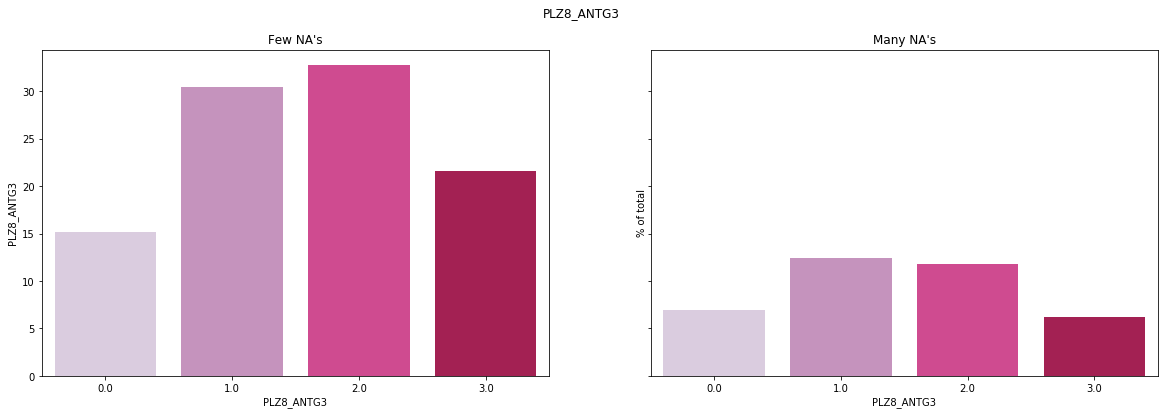

In [23]:
for i in list(azdias.columns[azdias.isnull().any()].to_series().sample(10)):
    compare_dist(azdias_row_na, i, 8)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The threshold for number of missing observations per row is 18 for this analysis. Further inspection reveals that this would drop approximately 10.7% of the rows in the original data set. The function for compares the distribution of features with less than 8 missing values and more than 8 missing values for 10 randomly selected features. For some, there are obvious discrepancies in the distributions, likely because there are so few individuals with more then 8 missing responses. For other features, the distributions remain similar.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_grouped = feat_info.groupby('type').count().sort_values(by = 'attribute', ascending=False)
feat_grouped.reset_index(inplace=True)
print(feat_grouped)

          type  attribute  information_level  missing_or_unknown
0      ordinal         49                 49                  49
1  categorical         21                 21                  21
2        mixed          7                  7                   7
3      numeric          7                  7                   7
4     interval          1                  1                   1


Text(0.5,1,'Count of Data Types')

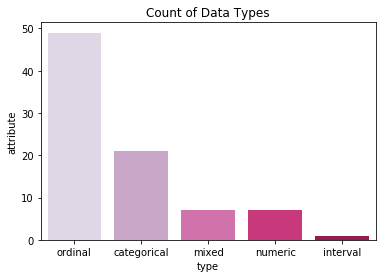

In [21]:
sns.barplot(x='type', y='attribute', data=feat_grouped, palette="PuRd")
plt.title("Count of Data Types")

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_variables = list(feat_info[feat_info['type'] == 'categorical']['attribute'].values)
_=azdias[cat_variables].apply(lambda x: print(x.name, ':', x.unique()))

AGER_TYP : [nan 2.0 3.0 1.0]
ANREDE_KZ : [1 2]
CJT_GESAMTTYP : [2.0 5.0 3.0 4.0 1.0 6.0 nan]
FINANZTYP : [4 1 6 5 2 3]
GFK_URLAUBERTYP : [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [2.0 5.0 1.0 nan 10.0 7.0 11.0 3.0 8.0 4.0 6.0 9.0]
LP_FAMILIE_GROB : [2.0 3.0 1.0 nan 5.0 4.0]
LP_STATUS_FEIN : [1.0 2.0 3.0 9.0 4.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB : [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ : [nan 1.0 3.0 2.0]
SHOPPER_TYP : [nan 3.0 2.0 1.0 0.0]
SOHO_KZ : [nan 1.0 0.0]
TITEL_KZ : [nan 4.0 1.0 3.0 5.0 2.0]
VERS_TYP : [nan 2.0 1.0]
ZABEOTYP : [3 5 4 1 6 2]
KK_KUNDENTYP : [nan 1.0 3.0 6.0 4.0 2.0 5.0]
GEBAEUDETYP : [nan 8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ : [nan 'W' 'O']
CAMEO_DEUG_2015 : [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis
OST_WEST_KZ_dummy = pd.get_dummies(azdias['OST_WEST_KZ']).loc[:, 'W':].rename(columns=lambda x: 'OST_WEST_KZ_' + str(x))
azdias_3 = pd.concat([azdias, OST_WEST_KZ_dummy], axis=1)
azdias_3.drop('OST_WEST_KZ', axis=1, inplace=True)
#list(azdias_3.columns)

In [23]:
# one-hot encode 'CAMEO_DEUG_2015'
CAMEO_DEUG_2015_dummy = pd.get_dummies(azdias['CAMEO_DEUG_2015']).rename(columns=lambda x: 'CAMEO_DEUG_2015_' + str(x))
azdias_4 = pd.concat([azdias, CAMEO_DEUG_2015_dummy], axis=1)
azdias_4.drop('CAMEO_DEUG_2015', axis=1, inplace=True)

In [24]:
# drop CAMEO_DEU_2015
azdias_5 = azdias.drop('CAMEO_DEU_2015', axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are three categorical features that take on non-numeric values: 'OST_WEST_KZ', 'CAMEO_DEUG_2015', and 'CAMEO_DEU_2015'. 

The feature 'OST_WEST_KZ' only has two levels, so it was converted into a dummy variable. The new column is labeled 'W' and indicates 1 if 'OST_WEST_KZ' takes on W and 0 if O. 

After reading the data dictionary, it was decided that its best the feature 'CAMEO_DEUG_2015' get one-hot encoded. The feature  'CAMEO_DEU_2015' was dropped as it contained similar, but more granular information as 'CAMEO_DEUG_2015'. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
mixed_variables = list(feat_info[feat_info['type'] == 'mixed']['attribute'].values)
_=azdias[mixed_variables].apply(lambda x: print(x.name, ':', x.unique()))

LP_LEBENSPHASE_FEIN : [15.0 21.0 3.0 nan 32.0 8.0 2.0 5.0 10.0 4.0 6.0 23.0 12.0 20.0 1.0 11.0
 25.0 13.0 7.0 18.0 31.0 19.0 38.0 35.0 30.0 22.0 14.0 33.0 29.0 24.0 28.0
 37.0 26.0 39.0 27.0 36.0 9.0 34.0 40.0 16.0 17.0]
LP_LEBENSPHASE_GROB : [4.0 6.0 1.0 nan 10.0 2.0 3.0 5.0 7.0 12.0 11.0 9.0 8.0]
PRAEGENDE_JUGENDJAHRE : [nan 14.0 15.0 8.0 3.0 10.0 11.0 5.0 9.0 6.0 4.0 2.0 1.0 12.0 13.0 7.0]
WOHNLAGE : [nan 4.0 2.0 7.0 3.0 5.0 1.0 8.0 0.0]
CAMEO_INTL_2015 : [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
KBA05_BAUMAX : [nan 5.0 1.0 2.0 3.0 4.0]
PLZ8_BAUMAX : [nan 1.0 2.0 4.0 5.0 3.0]


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Text(0.5,1,'Count of PRAEGENDE_JUGENDJAHRE Unique Values')

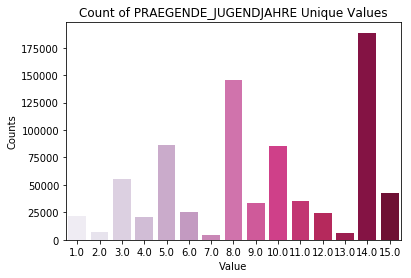

In [27]:
PJ_counts = pd.DataFrame(azdias.PRAEGENDE_JUGENDJAHRE.value_counts())
PJ_counts.columns = ['Counts']
PJ_counts['Value'] = PJ_counts.index

sns.barplot(x='Value', y='Counts', data=PJ_counts, palette="PuRd")
plt.title("Count of PRAEGENDE_JUGENDJAHRE Unique Values")

In [28]:
PJ_map = pd.DataFrame({-1: [np.nan, np.nan],
                       0: [np.nan, np.nan],
                       1: [40, 1],
                       2: [40, 0],
                       3: [50, 1],
                       4: [50, 0],
                       5: [60, 1],
                       6: [60, 0],
                       7: [60, 0],
                       8: [70, 1],
                       9: [70, 0],
                       10: [80, 1],
                       11: [80, 0],
                       12: [80, 1],
                       13: [80, 0],
                       14: [90, 1],
                       15: [90, 0],
                      np.nan: [np.nan, np.nan]}).T

decade_map = PJ_map[0].to_dict()
azdias['PRAEGENDE_JUGENDJAHRE_decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

movement_map = PJ_map[1].to_dict()
azdias['PRAEGENDE_JUGENDJAHRE_movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
CI_counts = pd.DataFrame(azdias.CAMEO_INTL_2015.value_counts())
CI_counts.columns = ['Counts']
CI_counts['Value'] = CI_counts.index

sns.barplot(x='Value', y='Counts', data=CI_counts, palette="PuRd")
plt.title("Count of CAMEO_INTL_2015 Unique Values")

Text(0.5,1,'Count of CAMEO_INTL_2015 Unique Values')

In [30]:
azdias['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])//10
azdias['CAMEO_INTL_2015_LIFE_STAGE'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])%10

In [31]:
azdias_6 = azdias.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','KBA05_BAUMAX','PLZ8_BAUMAX'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The two mixed features that are kept were PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, all the rest were drop for simplicity. 

The feature PRAEGENDE_JUGENDJAHRE was broken up into two seperate features, splitting by bothe decade and the type of movement happening at the individuals' youth (advantgard or mainstream).

The feature CAMEO_INTL_2015 was split into two numeric features, wealth and lifestage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_clean = azdias.drop(outlier_rows)
azdias_clean.drop(outlier_cols, axis=1, inplace=True)
azdias_clean.drop(['CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015',
                   'OST_WEST_KZ',
                   'LP_LEBENSPHASE_FEIN',
                   'LP_LEBENSPHASE_GROB',
                   'WOHNLAGE',
                   'PLZ8_BAUMAX'], 
                  axis=1, inplace=True)

In [33]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
list(azdias_clean.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RA

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info['missing_or_unknown'].replace({'[-1,X]':'[-1,"X"]',
                                        '[-1,XX]':'[-1,"XX"]',
                                         '[XX]':'["XX"]',
                                        }, inplace=True)
    na_encodings = feat_info.set_index('attribute')['missing_or_unknown'].to_dict()
    na_encodings = {key: {k: np.nan for k in literal_eval(value)} for key, value in na_encodings.items()} 
    
    for column, mapping in na_encodings.items():
        df[column].replace(mapping, inplace = True)
    
    df_col_na = pd.DataFrame(df.isnull().sum())
    df_col_na.columns = ['col_na_count']
    outlier_cols = list(df_col_na[df_col_na['col_na_count'] > 180000].index)

    df_row_na = pd.DataFrame(df.isnull().sum(axis=1))
    df_row_na.columns = ['row_na_count']
    outlier_rows = list(df_row_na[df_row_na['row_na_count'] > 18].index)
        
    # remove selected columns and rows, ...
    df_clean = df.drop(outlier_rows)
    df_clean.drop(outlier_cols, axis=1, inplace=True)
    df_clean.drop(['CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015',
                   'OST_WEST_KZ',
                   'LP_LEBENSPHASE_FEIN',
                   'LP_LEBENSPHASE_GROB',
                   'WOHNLAGE',
                   'PLZ8_BAUMAX'], 
                  axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    PJ_map = pd.DataFrame({-1: [np.nan, np.nan],
                       0: [np.nan, np.nan],
                       1: [40, 1],
                       2: [40, 0],
                       3: [50, 1],
                       4: [50, 0],
                       5: [60, 1],
                       6: [60, 0],
                       7: [60, 0],
                       8: [70, 1],
                       9: [70, 0],
                       10: [80, 1],
                       11: [80, 0],
                       12: [80, 1],
                       13: [80, 0],
                       14: [90, 1],
                       15: [90, 0],
                      np.nan: [np.nan, np.nan]}).T

    decade_map = PJ_map[0].to_dict()
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

    movement_map = PJ_map[1].to_dict()
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    
    df['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'])//10
    df['CAMEO_INTL_2015_LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'])%10
    
    # Return the cleaned dataframe.
    return df
    

In [35]:
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
df_clean = clean_data(azdias)

In [36]:
df_clean.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER             ...              \
count          891221.000000     891221.000000             ...               
mean                2.874167          3.075121             ...               
std                 1.486731          1.353248             ...               
min                 1.000000          1.000000             ...               
25%                 2.000000          2.000000             ...               
50%                 3.000000          3.000000             ...               
75%                 4.000000          4.000000             ...               
max                 5.000000          5.000000             ...               

         PLZ8_BAUMAX       PLZ8_HHZ       PLZ8_GBZ         ARBEIT  \
count  774706.000000  774706.000000  774706.000000  793846.000000   
mean        1.943913       3.612821       3.381087       3.166686   
std         1.459654       0.973967       1.111598       0.999072   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       3.000000       3.000000       3.000000   
50%         1.000000       4.000000       3.000000       3.000000   
75%         3.000000       4.000000       4.000000       4.000000   
max         5.000000       5.000000       5.000000       5.000000   

         ORTSGR_KLS9       RELAT_AB  PRAEGENDE_JUGENDJAHRE_decade  \
count  793947.000000  793846.000000                 783057.000000   
mean        5.293389       3.071033                     73.328046   
std         2.303379       1.360532                     14.592844   
min         1.000000       1.000000                     40.000000   
25%         4.000000       2.000000                     60.000000   
50%         5.000000       3.000000                     70.000000   
75%         7.000000       4.000000                     90.000000   
max         9.000000       5.000000                     90.000000   

       PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_WEALTH  \
count                    783057.00000           791869.000000   
mean                          0.77623                3.262098   
std                           0.41677                1.464494   
min                           0.00000                1.000000   
25%                           1.00000                2.000000   
50%                           1.00000                4.000000   
75%                           1.00000                5.000000   
max                           1.00000                5.000000   

       CAMEO_INTL_2015_LIFE_STAGE  
count               791869.000000  
mean                     2.8

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_clean.drop(['AGER_TYP','OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [39]:
imputer = Imputer()
imputer_model = imputer.fit(df_clean)
df_imputed = pd.DataFrame(imputer_model.transform(df_clean), columns = list(df_clean.columns))

In [40]:
# Apply feature scaling to the general population demographics data.
scalar = StandardScaler()
scalar_model = scalar.fit(df_imputed)
df_scaled = pd.DataFrame(scalar_model.transform(df_imputed), columns = list(df_clean.columns))

In [41]:
# check for any Na's
df_scaled.isna().any()
# looks good!

ALTERSKATEGORIE_GROB              False
ANREDE_KZ                         False
CJT_GESAMTTYP                     False
FINANZ_MINIMALIST                 False
FINANZ_SPARER                     False
FINANZ_VORSORGER                  False
FINANZ_ANLEGER                    False
FINANZ_UNAUFFAELLIGER             False
FINANZ_HAUSBAUER                  False
FINANZTYP                         False
GEBURTSJAHR                       False
GFK_URLAUBERTYP                   False
GREEN_AVANTGARDE                  False
HEALTH_TYP                        False
LP_LEBENSPHASE_FEIN               False
LP_LEBENSPHASE_GROB               False
LP_FAMILIE_FEIN                   False
LP_FAMILIE_GROB                   False
LP_STATUS_FEIN                    False
LP_STATUS_GROB                    False
NATIONALITAET_KZ                  False
PRAEGENDE_JUGENDJAHRE             False
RETOURTYP_BK_S                    False
SEMIO_SOZ                         False
SEMIO_FAM                         False


### Discussion 2.1: Apply Feature Scaling

At the beginning of this section, a few columns with NA's were dropped, then remaining missing values were imputed using sklearn Imputer. The scaling method chosen for this analysis is a Standard Scaler, which was applied to the imputed data set.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.
pca = PCA()
pca_mod = pca.fit(df_scaled)
pca_mod1 = pca.fit_transform(df_scaled)

In [43]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca_mod.explained_variance_ratio_))
plt.axhline(y=0.8, color='g', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');


In [44]:
plt.plot(pca_mod.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('explained variance')


Text(0,0.5,'explained variance')

In [50]:
print(pca_mod.explained_variance_ratio_)
print(np.cumsum(pca_mod.explained_variance_ratio_))

[  1.64301373e-01   1.23103362e-01   7.30587808e-02   5.57158954e-02
   4.03383152e-02   2.83338056e-02   2.53155597e-02   2.28400742e-02
   2.08211265e-02   1.89910049e-02   1.81649167e-02   1.75782739e-02
   1.51833808e-02   1.45105887e-02   1.38715721e-02   1.34583941e-02
   1.24155865e-02   1.19290269e-02   1.19160874e-02   1.18824645e-02
   1.17724896e-02   1.14682911e-02   1.07813313e-02   1.07357260e-02
   1.05560594e-02   9.94872839e-03   9.84836108e-03   9.49271522e-03
   9.22305211e-03   9.03906741e-03   8.55351677e-03   8.34089984e-03
   8.28124550e-03   7.80478854e-03   7.69861965e-03   7.24530949e-03
   6.50501714e-03   6.15551101e-03   6.00767683e-03   5.59502019e-03
   5.56064580e-03   5.33365634e-03   5.20641276e-03   5.12772884e-03
   4.84980205e-03   4.71249226e-03   4.59968523e-03   4.55374254e-03
   4.21486369e-03   3.69971405e-03   3.55551969e-03   3.50984579e-03
   3.35953519e-03   3.20788615e-03   3.17653806e-03   3.14243225e-03
   2.93752015e-03   2.89493287e-03

In [45]:
pca = PCA(n_components=30)
pca_mod = pca.fit(df_scaled)
azdias_pca = pca_mod.transform(df_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Based off the PCA analysis above, it appears that a selection of 30 principal components will capture over 80% of the variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def loadings(pca, comp_number, features):
    '''
    Prints the loadings of each feature for a particular set of components.
    INPUT: pca object, number of component, and feature names
    '''
    comp_loading = pd.DataFrame(pca.components_, columns=list(df_scaled.columns))
    loads = pd.DataFrame(comp_loading.iloc[comp_number + 1,:].transpose().sort_values(ascending=False))
    loads.columns = ['weights']
    
    return loads.head(6), loads.tail(6).sort_values('weights') 

In [47]:
def plot_loadings(head_df, tail_df, PC_number):
    '''
    Plots the loadings of each component.
    INPUT: Top 6 loadings, bottom 6 loadings (from loadings function), and PCA number.
    '''
    
    ind = np.arange(len(head_df))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (16, 5))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    ax1.set_title('Highest Loadings')
    ax2.set_title('Lowest Loadings')
    sns.barplot(x = head_df.index, y = head_df['weights'],  ax = ax1, palette="PuRd")
    sns.barplot(x = tail_df.index, y = tail_df['weights'], ax = ax2, data = tail_df, palette="PuRd")
    
    for i in range(len(head_df)):
        ax1.annotate(r"%s%%" % ((str(head_df['weights'][i]*100)[:4])), (ind[i] , -0.06), 
                    va="bottom", ha="center", fontsize=12)
        ax2.annotate(r"%s%%" % ((str(tail_df['weights'][i]*100)[:5])), (ind[i] , 0.02), 
                    va="bottom", ha="center", fontsize=12)
        plt.ylabel('Loadings')
        plt.suptitle('Principal Component ' + str(PC_number))

In [54]:
comp_1_head, comp_1_tail = loadings(pca_mod, 1, list(df_scaled.columns))
plot_loadings(comp_1_head, comp_1_tail, 1)

In [55]:
print(comp_1_head)
print(comp_1_tail)

                    weights
SEMIO_VERT         0.339757
SEMIO_KULT         0.295969
SEMIO_SOZ          0.286933
SEMIO_FAM          0.254285
FINANZ_MINIMALIST  0.121623
SEMIO_REL          0.091308
              weights
ANREDE_KZ   -0.358786
SEMIO_KAEM  -0.354985
SEMIO_DOM   -0.325201
SEMIO_KRIT  -0.301725
SEMIO_ERL   -0.206291
SHOPPER_TYP -0.154210


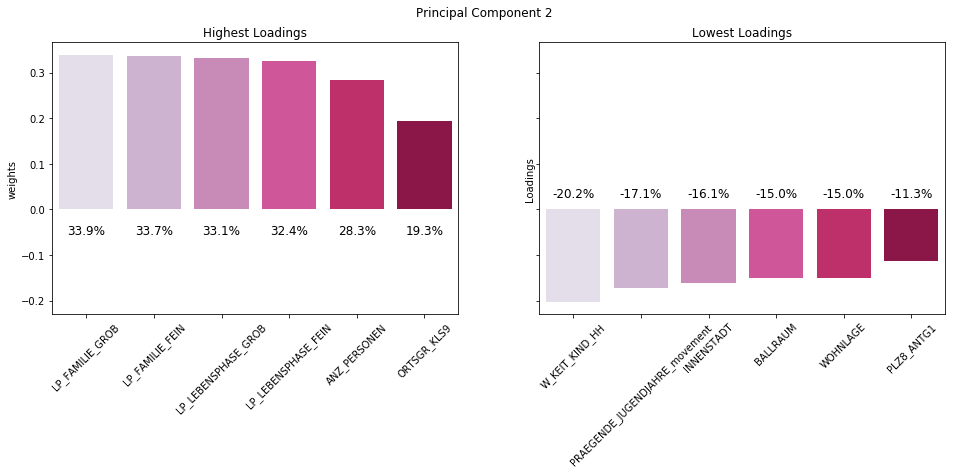

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_2_head, comp_2_tail = loadings(pca_mod, 2, list(df_scaled.columns))
plot_loadings(comp_2_head, comp_2_tail, 2)

In [57]:
print(comp_2_head)
print(comp_2_tail)

                      weights
LP_FAMILIE_GROB      0.339183
LP_FAMILIE_FEIN      0.337364
LP_LEBENSPHASE_GROB  0.331618
LP_LEBENSPHASE_FEIN  0.324440
ANZ_PERSONEN         0.283001
ORTSGR_KLS9          0.193663
                                 weights
W_KEIT_KIND_HH                 -0.202587
PRAEGENDE_JUGENDJAHRE_movement -0.171560
INNENSTADT                     -0.161593
BALLRAUM                       -0.150806
WOHNLAGE                       -0.150557
PLZ8_ANTG1                     -0.113504


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_3_head, comp_3_tail = loadings(pca_mod, 3, list(df_scaled.columns))
plot_loadings(comp_3_head, comp_3_tail, 3)


In [59]:
print(comp_3_head)
print(comp_3_tail)

                                 weights
PRAEGENDE_JUGENDJAHRE_movement  0.328762
KKK                             0.260429
WOHNLAGE                        0.238456
LP_FAMILIE_FEIN                 0.220791
LP_FAMILIE_GROB                 0.220530
HH_EINKOMMEN_SCORE              0.212106
                   weights
GREEN_AVANTGARDE -0.315605
EWDICHTE         -0.192122
ORTSGR_KLS9      -0.186549
LP_STATUS_GROB   -0.137411
PLZ8_HHZ         -0.130067
W_KEIT_KIND_HH   -0.119156


### Discussion 2.3: Interpret Principal Components

##### PCA 1:

The top loadings are SEMIO_KULT, SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_REL, FINANZ_MINIMALIST. The bottom loadings are SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL, ANREDE_KZ, and SHOPPER_TYP. Based off the information from the data dictionary individuals in this first component are likely female, uniterested in finance, cultural, dreamers, family-oriented, social, religious, non-dominant, non-combative, non-event oriented, non-critical, and likes shopping.

##### PCA 2:

The top loadings are LP_FAMILIE_GROB, LP_FAMILIE_FEIN, LP_LEBENSPHASE_GROB, LP_LEBENSPHASE_FEIN, ANZ_PERSONEN, and ORTSGR_KLS9. The bottom loadings are W_KEIT_KIND_HH, PRAEGENDE_JUGENDJAHRE_movement, INNENSTADT, BALLRAUM , WOHNLAGE, and PLZ8_ANTG1.
Individuals in this principal component come from a big and multigenerational fmaily, multiperson households, a large number of adults in the household, from large communities, not from cities with few buildings, located close to a city center, not from a rural community, avantgard, and high liklihood of children in the house.


##### PCA 3:

The top loadings are PRAEGENDE_JUGENDJAHRE_movement, KKK, WOHNLAGE, LP_FAMILIE_FEIN, LP_FAMILIE_GROB and HH_EINKOMMEN_SCORE. Th bottom loadings are GREEN_AVANTGARDE, EWDICHTE, ORTSGR_KLS9, LP_STATUS_GROB, PLZ8_HHZ and W_KEIT_KIND_HH.
Individuals in this principal component are likely mainstream, rural, big and multigenerational fmaily, low purchasing power, low housegold income, not a member of green avantgarde, high liklihood of children in the house, low density of households per square kilometer, not from a large population community, low number of households within the PLZ8 region, and likely low income earners.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Over a number of different cluster counts...
n_clust = [2,5,7,10,15]
average_dist = []
for i in n_clust:
    # run k-means clustering on the data and...
    km = KMeans(i)
    km.fit(azdias_pca)
    # compute the average within-cluster distances.
    average_dist.append(-km.score(azdias_pca))
    

In [50]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 8))
plt.plot(n_clust, average_dist,  linestyle='-', marker='o', color = 'pink')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance Between Points and Cluster Center VS. Number of Clusters')
plt.show()


In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
marginal_change = np.diff(average_dist)
optimal_n_clusters = n_clust[np.argmin(abs(marginal_change)) - 1]
print(marginal_change)
print(optimal_n_clusters)

[-9430873.17160124 -2858470.27530222 -2750170.05472246 -2843437.21249835]
5


In [54]:
kmeans2 = KMeans(optimal_n_clusters)
optimal_kmeans = kmeans2.fit(azdias_pca)
df_imputed['clusters'] = optimal_kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

There was no clear elbow in the KMeans average distance plot, therefore the cluster was chosen as the last cluster that has the smallest margin from the last cluster. This approach was taken since the average distance does not tend to increase as the number of clusters increases. This resulted in an optimal cluster number of 5.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ";")

In [63]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_clean.drop(['AGER_TYP','OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

imputer_model = imputer.fit(customers_clean)
customers_imputed = pd.DataFrame(imputer_model.transform(customers_clean), columns = list(customers_clean.columns))

scalar_model = scalar.fit(customers_imputed)
customers_scaled = pd.DataFrame(scalar_model.transform(customers_imputed), columns = list(customers_clean.columns))


In [64]:
customers_pca_mod = pca.fit(customers_scaled)
customers_pca = customers_pca_mod.transform(customers_scaled)

In [65]:
kmeans2 = KMeans(optimal_n_clusters)
customers_optimal_kmeans = kmeans2.fit(customers_pca)
customers_imputed['clusters'] = customers_optimal_kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_n_clusters = pd.DataFrame(df_imputed.groupby(['clusters'], as_index=False).count().iloc[:, :2])
azdias_n_clusters.iloc[:, 1] = azdias_n_clusters.iloc[:, 1]/sum(azdias_n_clusters.iloc[:, 1])*100
azdias_n_clusters['dataset'] = 'General'

customers_n_clusters = pd.DataFrame(customers_imputed.groupby(['clusters'], as_index=False).count().iloc[:, :2])
customers_n_clusters.iloc[:, 1] = customers_n_clusters.iloc[:, 1]/sum(customers_n_clusters.iloc[:, 1])*100
customers_n_clusters['dataset'] = 'Customers'


In [67]:
clusters_cnt = pd.concat([azdias_n_clusters, customers_n_clusters])
clusters_cnt.columns = ['clusters','percentage %','dataset']

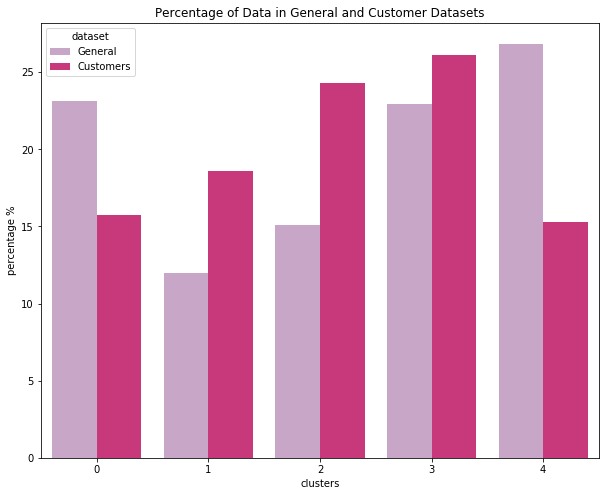

In [68]:
plt.figure(figsize=(10,8))
sns.barplot(x='clusters', y='percentage %', data=clusters_cnt, hue='dataset', palette="PuRd")
plt.title('Percentage of Data in General and Customer Datasets')
plt.show()

In [69]:
clusters_pivot = clusters_cnt.pivot(index = 'clusters', columns='dataset', values='percentage %')
clusters_pivot['difference %'] = clusters_pivot['Customers'] - clusters_pivot['General']

In [70]:
def centroid_func(n_centroids, feature_names, customers):
    """
    Get the features given the cluster centroid numbers
    """
    centroids = customers[customers['clusters'].isin(n_centroids)]
    return pd.DataFrame(centroids.iloc[:, :-1].mean()).T

In [71]:
def mean_rest(n_centroids, customers):
    """
    Get the mean of the rest of the data
    """
    rest_customers = customers[~customers['clusters'].isin(n_centroids)]
    return pd.DataFrame(rest_customers.iloc[:, :-1].mean()).T

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented  = list(clusters_pivot['difference %'].sort_values(ascending = False).head(2).index)
over_clusters_diff = pd.concat([centroid_func([overrepresented[0]], list(customers.columns), customers_imputed ), 
                           centroid_func([overrepresented[1]], list(customers.columns), customers_imputed), 
                           mean_rest(overrepresented, customers_imputed)])
over_clusters_diff.set_index(pd.Series(overrepresented + ['rest']), inplace = True)

over_average_diff = (abs(over_clusters_diff.loc[overrepresented[0]] - over_clusters_diff.loc['rest']) 
                + abs(over_clusters_diff.loc[overrepresented[1]] - over_clusters_diff.loc['rest']))/2
over_top5_diff = list(over_average_diff.sort_values(ascending = False).head(5).index)

In [73]:
over_clusters_diff[over_top5_diff]

KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN  ANZ_HAUSHALTE_AKTIV  \
2           703.868382            35.964922             1.555850   
1           697.641231            16.507702             2.101738   
rest        641.729639            21.997489             7.503420   

      PRAEGENDE_JUGENDJAHRE_decade  LP_FAMILIE_FEIN  
2                        62.039718         9.806748  
1                        53.863310         2.053298  
rest                     59.138730         5.112261

In [82]:
over_plot_data = pd.DataFrame(over_clusters_diff[over_top5_diff].apply(lambda x: x/ max(x)).T)
over_plot_data2 = over_plot_data.stack()
over_plot_data2 = over_plot_data2.reset_index()
over_plot_data2.columns = ['Feature', 'Cluster', 'Max Difference']

In [75]:
plt.figure(figsize=(10,8))
sns.barplot(x='Feature', y='Max Difference', data=over_plot_data2, hue='Cluster',  palette="PuRd")
plt.title('Top 5 Features with the Maximum Difference betweeen Datasets - Overrepresented')
plt.xticks(rotation = 45)
plt.show()

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented = list(clusters_pivot['difference %'].sort_values(ascending = False).dropna().tail(2).index)

under_clusters_diff = pd.concat([centroid_func([underrepresented[0]], list(customers.columns),customers_imputed), 
                           centroid_func([underrepresented[1]], list(customers.columns), customers_imputed), 
                           mean_rest(underrepresented, customers_imputed)])
under_clusters_diff.set_index(pd.Series(underrepresented + ['rest']), inplace = True)

under_average_diff = (abs(under_clusters_diff.loc[underrepresented[0]] - under_clusters_diff.loc['rest']) 
                + abs(under_clusters_diff.loc[underrepresented[1]] - under_clusters_diff.loc['rest']))/2
under_top5_diff = list(under_average_diff.sort_values(ascending=False).head(5).index)

In [78]:
under_clusters_diff[under_top5_diff]

KBA13_ANZAHL_PKW  ANZ_HAUSHALTE_AKTIV  LP_LEBENSPHASE_FEIN  \
0           549.191645            16.890090            15.810580   
4           691.192520             2.159418            24.219119   
rest        688.815643             2.997501            26.350501   

      LP_STATUS_FEIN  SEMIO_REL  
0           2.482901   2.947786  
4           7.979063   1.898354  
rest        7.359916   4.868646

In [81]:
under_plot_data = pd.DataFrame(under_clusters_diff[under_top5_diff].apply(lambda x: x/ max(x)).T)
under_plot_data2 = under_plot_data.stack()
under_plot_data2 = under_plot_data2.reset_index()
under_plot_data2.columns = ['Feature', 'Cluster', 'Max Difference']

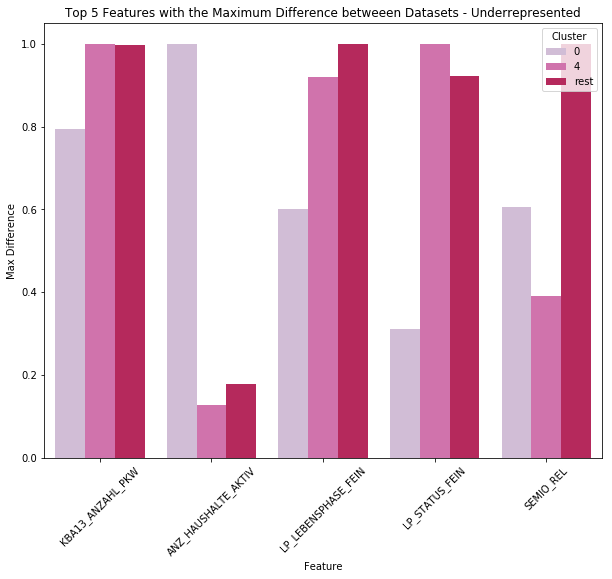

In [80]:
plt.figure(figsize=(10,8))
sns.barplot(x='Feature', y='Max Difference', data=under_plot_data2, hue='Cluster',  palette="PuRd")
plt.title('Top 5 Features with the Maximum Difference betweeen Datasets - Underrepresented')
plt.xticks(rotation = 45)
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

There appears to be some key differences between the general and customer data sets. The general data set has a higher proportion of data in clusters 1 and 5 than the customer dataset. Alternatively, the customer data set has a higher proportion of data in clusters 2, 3, and 4 than the general data set.

The analysis includes a closer inspection into which features have the biggest over-representation and under-representation in each of the features from the customer data set in comparison to the general dataset. 


#### Over-represented Customer Groups:

The top five features that are over-represented in the customer data set are KBA13_ANZAHL_PKW, LP_LEBENSPHASE_FEIN, ANZ_HAUSHALTE_AKTIV, PRAEGENDE_JUGENDJAHRE_decade, and LP_LEBENSPHASE_GROB.

###### Cluster 3:

This cluster reveals customers that fall into this cluster live in an area with slightly more cars per region than the other clusters (704 cars), come from a multi-person household (avg score: 35.9), approximately 1.6 households per building, are slightly older than the rest of the groups, and live in a two generational household on average.

###### Cluster 2:

This cluster reveals customers that fall into this cluster live in an area with 697 cars per region (less than cluster 3 and more than the other clusters), come from a higher age household (avg score: 16.5), approximately 2.1 households per building, are slightly younger than the rest of the groups, and live in a two-person or couple household.

###### All other clusters:

The remaining clusters reveal customers live in an area with 642 cars per region, come from a family style household (avg score: 22), approximately 7.5 households per building, are sneither older or younger than rest of the cluster, and live in a single generational household on average.



#### Under-represented:

The top five features that are under-represented in the customer data set are KBA13_ANZAHL_PKW, ANZ_HAUSHALTE_AKTIV, LP_LEBENSPHASE_FEIN, LP_STATUS_FEIN, and SEMIO_REL.

###### Cluster 1:

This cluster reveals individuals who are not customers that fall into this cluster live in an area with 549 cars per region on average, approximately 17 households per building, come from couple-level household (avg score: 15.8), are typically low earners (avg score: 2.5), and are typically very religious.

###### Cluster 5:

This cluster reveals individuals who are not customers that fall into this cluster live in an area with 691 cars per region on average, approximately 2.2 households per building, come from low income family-level household (avg score: 24.3), typically own a home (avg score: 7.9), and are typically extremely religious.

###### All other clusters:

This cluster reveals individuals who are not customers that fall into the remaining clusters live in an area with 688 cars per region on average, approximately 2.9 households per building, come from family-level household (avg score: 26.3), typically own a home (avg score: 7.4), and are typically moderately religious.


#### Final Words:

The typical customer for this mail order company appear to be individuals who are slightly higher earners, live in couple or single family households, and live in denser areas - commonly associated with cities. This claim is supported by the cluster loadings of over-represented customers. The housing density and number of cars per region are higher than under-represented customers. Low income and religious affinity were overwhelming demographics of people who are not customers. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.